In [2]:
!pip -q install mplsoccer

import json
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 5.6 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()
EVENTS_FILE = "3895309.json"

Saving 3895309.json to 3895309.json


In [4]:
# --- Load StatsBomb events (raw list of dicts) ---
with open(EVENTS_FILE, "r", encoding="utf-8") as f:
    events = json.load(f)

# --- Fast lookup: event_uuid -> full event dict (useful for joining with 360 data) ---
events_by_id = {ev["id"]: ev for ev in events if "id" in ev}

# --- Discover team names present in this match (usually 2 teams) ---
all_teams = sorted({
    ev.get("team", {}).get("name")
    for ev in events
    if ev.get("team") and ev.get("team", {}).get("name")
})

# --- Optional: colors for plotting (fallback color will be handled later) ---
TEAM_COLORS = {
    "Borussia Dortmund": "yellow",
    "Bayer Leverkusen": "red",
}
"""
Mapping from team name -> matplotlib color name.
If a team isn't listed here, you can default to something like 'gray'.
"""

# --- Player metadata from 'Starting XI' / tactics events ---
player_info = {}
"""
Mapping from player_id -> {team, jersey, name} extracted from tactics lineups.
Note: This only populates for matches/events where 'tactics' info is present.
"""

for ev in events:
    tactics = ev.get("tactics")
    if not tactics:
        continue

    team_name = ev.get("team", {}).get("name", "Unknown")

    for lu in tactics.get("lineup", []):
        pid = lu["player"]["id"]
        player_info[pid] = {
            "team": team_name,
            "jersey": lu.get("jersey_number", ""),
            "name": lu["player"]["name"],
        }


def _other_team(team_name: str) -> str:
    """
    Return the opponent team name for `team_name` using `all_teams`.

    Assumes a standard match has two teams. If the match has unusual/missing team
    info, falls back to the first different team found, otherwise 'Unknown'.
    """
    if len(all_teams) >= 2 and team_name in all_teams:
        return all_teams[0] if all_teams[1] == team_name else all_teams[1]

    for t in all_teams:
        if t != team_name:
            return t

    return "Unknown"


In [5]:
def plot_event_snapshot(event_id: str):
    """
    Plot a single StatsBomb event as a quick visual snapshot for EDA.

    This function draws a StatsBomb-style pitch and overlays the key objects
    relevant to the event type (pass/shot/carry/ball receipt). It uses:
      - `events_by_id` to locate the event dict by event UUID
      - `player_info` (from tactics/starting XI) to label jersey numbers
      - `TEAM_COLORS` to color-code teams
      - `_other_team(team_name)` to infer opponent name

    Supported event types (best-effort):
      - "Pass": show passer, recipient (if available), pass arrow, and end point
      - "Shot": show freeze_frame players (if available), shooter, and shot end point
      - "Carry": show carry arrow and end point
      - "Ball Receipt*": show receipt location

    Parameters
    ----------
    event_id : str
        StatsBomb event UUID (the "id" field in the events JSON).

    Raises
    ------
    KeyError
        If `event_id` is not present in `events_by_id`.

    Notes
    -----
    - For many matches, `player_info` is only available if "tactics" events exist.
      If not found, jersey labels may be missing.
    - This is designed for EDA/debugging, not for publication-quality plots.
    """
    if event_id not in events_by_id:
        raise KeyError(f"Event id not found: {event_id}")

    ev = events_by_id[event_id]
    ev_type = ev.get("type", {}).get("name", "Unknown")
    team_name = ev.get("team", {}).get("name", "Unknown")
    minute = ev.get("minute", 0)
    second = ev.get("second", 0)

    # --- draw pitch ---
    pitch = Pitch(pitch_type="statsbomb", pitch_color="white", line_color="black")
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.suptitle(
        f"{team_name} – {ev_type}\nEvent {event_id} at {minute}:{second:02d}",
        fontsize=14,
    )

    # --- actor (main player) info ---
    actor_id = ev.get("player", {}).get("id")
    actor_meta = player_info.get(actor_id, {})
    actor_jersey = actor_meta.get("jersey", "")
    actor_team = actor_meta.get("team", team_name)
    actor_color = TEAM_COLORS.get(actor_team, "grey")

    start_loc = ev.get("location")  # [x, y] in StatsBomb coords

    def _draw_player(x, y, color, jersey=""):
        """Helper: draw a player marker + optional jersey text."""
        pitch.scatter(x, y, ax=ax, s=250, color=color, edgecolors="black", zorder=3)
        if jersey != "":
            ax.text(
                x, y, str(jersey),
                ha="center", va="center",
                fontsize=8, fontweight="bold",
                color="black", zorder=4
            )

    def _draw_actor_marker(x, y):
        """Helper: emphasize the actor/passer/shooter marker."""
        pitch.scatter(x, y, ax=ax, s=300, color=actor_color,
                      edgecolors="black", linewidth=2, zorder=5)
        if actor_jersey != "":
            ax.text(
                x, y, str(actor_jersey),
                ha="center", va="center",
                fontsize=9, fontweight="bold",
                color="black", zorder=6
            )

    def _draw_ball(x, y):
        """Helper: draw the ball as a small black dot."""
        pitch.scatter(x, y, ax=ax, s=80, color="black", zorder=7)

    # =========================
    # Event type-specific logic
    # =========================

    # --- SHOT (with optional freeze_frame) ---
    if ev_type == "Shot":
        shot = ev.get("shot", {})
        freeze = shot.get("freeze_frame")

        # draw freeze-frame players if available
        if freeze:
            opp_team = _other_team(actor_team)
            for p in freeze:
                x, y = p["location"]
                pid = p.get("player", {}).get("id")

                info = player_info.get(pid)
                if info:
                    team = info.get("team", "Unknown")
                    jersey = info.get("jersey", "")
                else:
                    team = actor_team if p.get("teammate") else opp_team
                    jersey = ""

                color = TEAM_COLORS.get(team, "grey")
                _draw_player(x, y, color, jersey)

        # shooter location
        if start_loc:
            sx, sy = start_loc
            _draw_actor_marker(sx, sy)

        # shot end location (ball)
        end_loc = shot.get("end_location")
        if end_loc and len(end_loc) >= 2:
            bx, by = end_loc[0], end_loc[1]
            _draw_ball(bx, by)

    # --- PASS ---
    elif ev_type == "Pass":
        # passer
        if start_loc:
            sx, sy = start_loc
            _draw_actor_marker(sx, sy)

        pdat = ev.get("pass", {})
        end = pdat.get("end_location")
        rec = pdat.get("recipient")

        if end and len(end) >= 2:
            rx, ry = end[0], end[1]
            rec_id = rec.get("id") if rec else None
            rec_jersey = player_info.get(rec_id, {}).get("jersey", "")

            # receiver marker (same color as actor team)
            _draw_player(rx, ry, actor_color, rec_jersey)

            # pass arrow
            if start_loc:
                pitch.arrows(
                    sx, sy, rx, ry, ax=ax, width=1,
                    headwidth=4, headlength=4, alpha=0.7, zorder=2
                )

            # ball at end (often helpful)
            _draw_ball(rx, ry)

    # --- BALL RECEIPT (and variants like "Ball Receipt*") ---
    elif ev_type.startswith("Ball Receipt"):
        if start_loc:
            rx, ry = start_loc
            _draw_actor_marker(rx, ry)
            _draw_ball(rx, ry)

    # --- CARRY ---
    elif ev_type == "Carry":
        if start_loc:
            sx, sy = start_loc
            _draw_actor_marker(sx, sy)

        end = ev.get("carry", {}).get("end_location")
        if end and len(end) >= 2:
            ex, ey = end[0], end[1]
            if start_loc:
                pitch.arrows(
                    sx, sy, ex, ey, ax=ax, width=1,
                    headwidth=4, headlength=4, alpha=0.7, zorder=2
                )
            _draw_ball(ex, ey)

    # --- fallback ---
    else:
        # For unknown events, just mark the start location if it exists.
        if start_loc:
            sx, sy = start_loc
            _draw_actor_marker(sx, sy)

    # --- Legend ---
    legend_teams = [t for t in TEAM_COLORS.keys() if t in all_teams] or all_teams[:2]
    legend_elems = [
        Patch(facecolor=TEAM_COLORS.get(t, "grey"), edgecolor="black", label=t)
        for t in legend_teams
    ]
    legend_elems.append(
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor="black", markeredgecolor="black",
               markersize=6, label="Ball")
    )

    ax.legend(
        handles=legend_elems,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(legend_elems),
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()


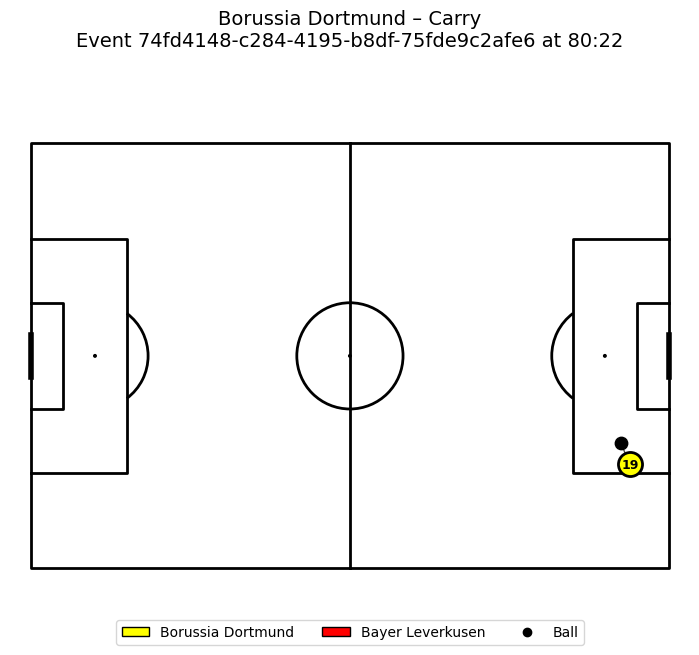

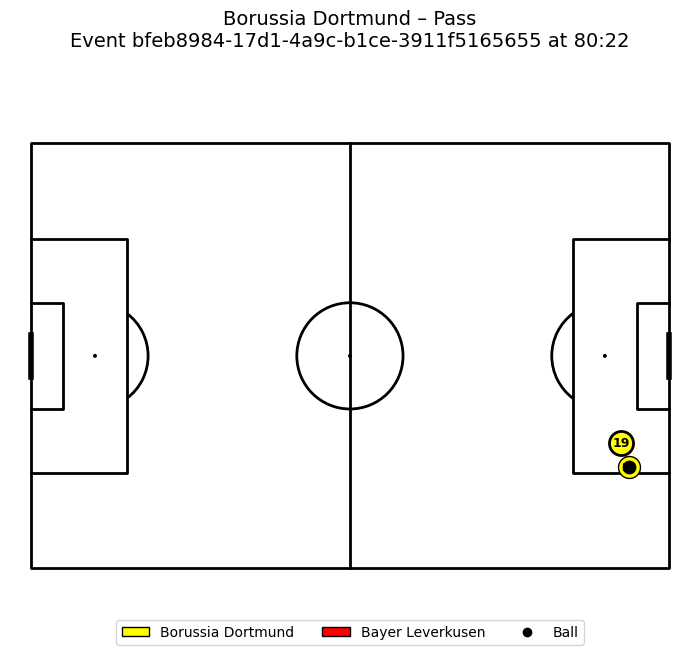

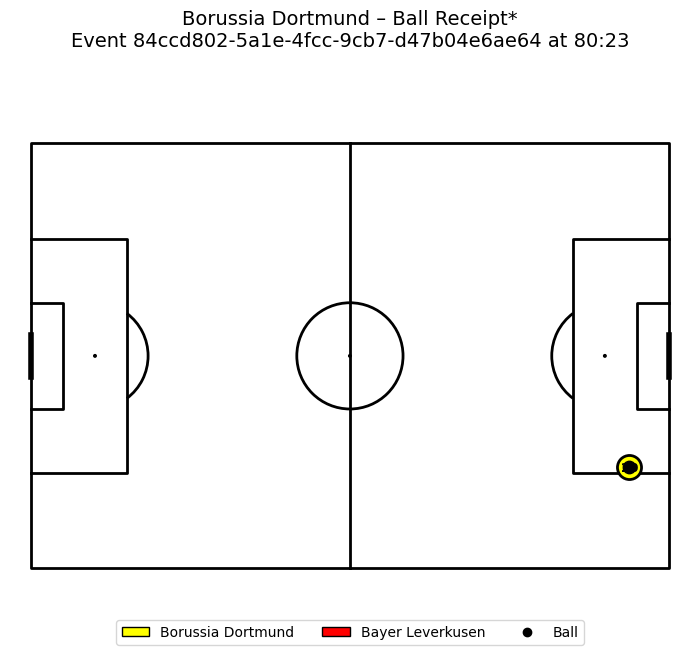

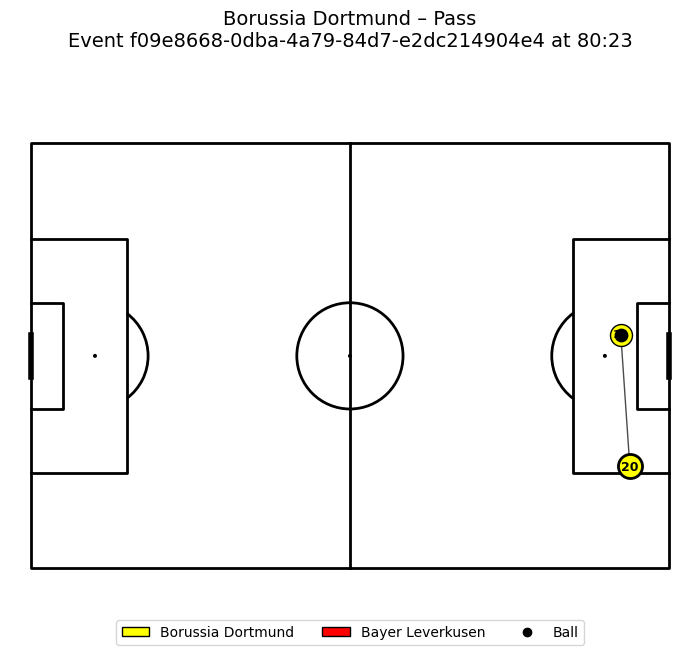

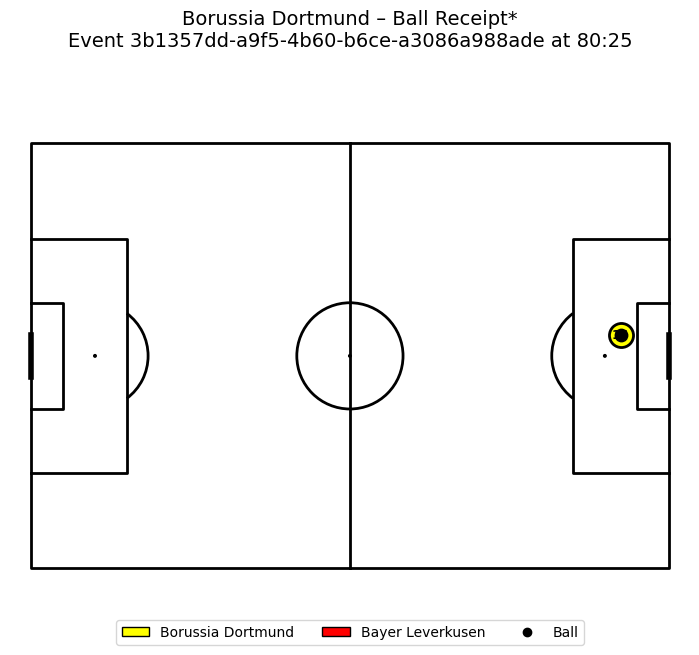

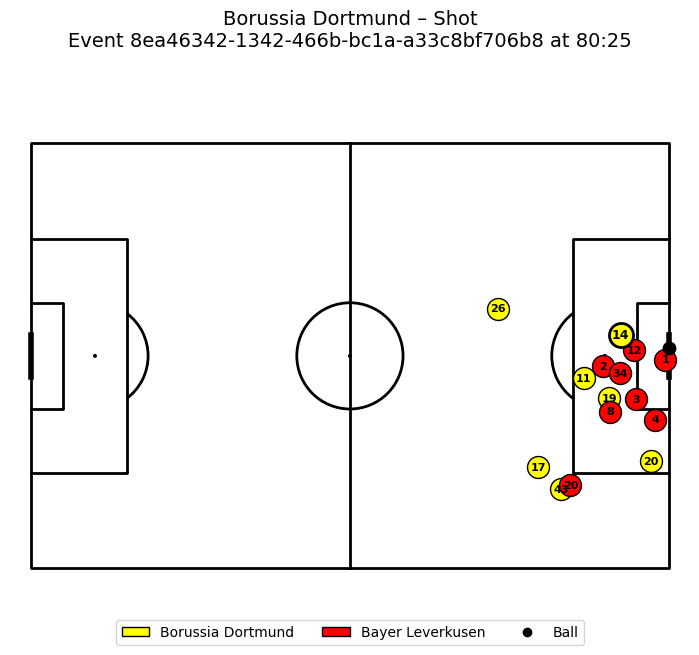

In [6]:
event_ids = [
    "74fd4148-c284-4195-b8df-75fde9c2afe6",
    "bfeb8984-17d1-4a9c-b1ce-3911f5165655",
    "84ccd802-5a1e-4fcc-9cb7-d47b04e6ae64",
    "f09e8668-0dba-4a79-84d7-e2dc214904e4",
    "3b1357dd-a9f5-4b60-b6ce-a3086a988ade",
    "8ea46342-1342-466b-bc1a-a33c8bf706b8",
]

for eid in event_ids:
    plot_event_snapshot(eid)
